
UCSanDiegoX: DSE200x Python for Data Science

# Final Project: Predictors of Attitudes towards Opioids (WORKING)

### Objective: To identify clusters of demographic and experiential variables that are associated with attitudes towards opioids.

### Method: Combine data from mutiple sources to create a variable identifying each survey response geography as urban, suburban, or rural. Conduct k-modes cluster analysis to determine whether there are clusters of demographic and experiential variables associated with attitudes towards opioids, including urban, suburban or rural geography.

Datasources:
1. Proprietary survey, n = 1,200
    
    - Geographic: _VGeoRegion_ (String): State; _Vpostal_ (String): Zip code
    - Demographic/Experiential: var9, var11, var12, var13, educrec, incomerec, var16, politrec, var217
    - Attitudinal:  var230, var231, var232, var233, var234, var235, var236, var237rec, var238rec, var239rec, var240rec, var241rec, var242rec, var243rec, var244rec, var245rec, var246, var247rec var248rec, var249rec, var250rec, var251rec, var252rec, var253rec, var254rec, var255rec
    

2. 2015 ZIP Code Tabulation Areas Gazetteer File, n = 33,144 
https://www.census.gov/geo/maps-data/data/gazetteer2015.html

    - _GEOID_: Five digit ZIP Code Tabulation Area Census Code; *ALAND_SQMI*: Land Area (square miles)
    

3. B25001 HOUSING UNITS by ZCTA, 2012-2016 American Community Survey 5-Year Estimates, n = 33,120 https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_16_5YR_B25001&prodType=table

    - _GEO.id2_: Five digit ZIP Code Tabulation Area Census Code; *HD01_VD01*: Housing Units, Estimated


### Identify each Zip Code Tabulation Area as Urban, Suburban, or Rural based on housing density

ZCTA housing density = Number of housing units in ZCTA/Square miles in ZCTA

Values:
0. Urban: >2,213 households per square mile; 
1. Suburban: 102 to 2,213 households per square mile; 
2. Rural: <102 households per square mile

Source: https://fivethirtyeight.com/features/how-suburban-are-big-american-cities/

In [1]:
import pandas as pd
import numpy as np

In [ ]:
# Read in Opioids survey dataset
df_opioids = pd.read_csv('OpioidsWKNG.csv')

In [ ]:
df_opioids.head()

In [ ]:
# Check zip code frequencies
df_opioids.Vpostal.value_counts()

In [ ]:
# Display rows with one or more null values
df_opioids[df_opioids.isnull().any(axis=1)]

In [ ]:
# Replace missing values ' ' in Vpostal with missing values np.nan objects
df_opioids['Vpostal'].replace(' ', np.nan, inplace=True)

In [ ]:
# Display rows with one or more null values
df_opioids[df_opioids.isnull().any(axis=1)]

In [ ]:
# Drop rows with missing values in Vpostal
df2_opioids=df_opioids.dropna(subset=['Vpostal'])

In [ ]:
# Check number of rows before and after dropna
before_rows = df_opioids.shape[0]
print(before_rows)

In [ ]:
after_rows = df2_opioids.shape[0]
print(after_rows)

In [ ]:
# Check how many of the remaining records have states attached
df2_opioids.VGeoRegion.value_counts()

In [ ]:
df2_opioids['Vpostal']

In [ ]:
# Check how many unique zip codes remain
df2_opioids['Vpostal'].nunique()

In [ ]:
# Create new GEOID variable by transforming Vpostal into an integer (stripping the leading zeros from Vpostal)
strip_Vpostal = df2_opioids['Vpostal'].apply(int)

In [ ]:
strip_Vpostal.head()

In [ ]:
len(strip_Vpostal)

In [ ]:
# Check zip codes count
strip_Vpostal.value_counts()

In [ ]:
df3_opioids = df2_opioids.assign(GEOID = strip_Vpostal)

In [ ]:
df3_opioids.head()

In [ ]:
# Check new column GEOID
GEOIDslice = ['Vrid', 'Vpostal','GEOID']
GEOIDcheck = df3_opioids[GEOIDslice]
print(GEOIDcheck)

In [ ]:
# Save records with zip codes as a new csv file
df3_opioids.to_csv("Opioids_ZCSubset.csv", index=False)

In [ ]:
# Read in ZIP Code Tabulation Areas Gazetteer File
df_ZCTA = pd.read_csv("2015_Gaz_zcta_national.txt", sep = "\t")
df_ZCTA.head()

In [ ]:
len(df_ZCTA.index)

In [ ]:
# Create dataset with GEOID and ALAND_SQMI only, save as .csv
features = ['GEOID', 'ALAND_SQMI']
df2_ZCTA = df_ZCTA[features]

In [ ]:
df2_ZCTA.head()

In [ ]:
# Save land area by ZCTA as a new csv file
df2_ZCTA.to_csv("LandArea_ZCTA.csv", index=False)

In [ ]:
# Read in housing unit counts by ZCTA from ACS data
df_HU = pd.read_csv("ACS_16_5YR_B25001_with_ann.csv", header=0, skiprows=[1])
df_HU.head()

In [ ]:
# Rename GEO.id2 to GEOID
df_HU.rename(columns = {'GEO.id2':'GEOID'}, inplace=True)
df_HU.head()

In [ ]:
# Create dataset with GEOID and HD01_VD01 only, save as .csv
features2 = ['GEOID', 'HD01_VD01']
df2_HU= df_HU[features2]

In [ ]:
df2_HU.head()

In [ ]:
len(df2_HU)

In [ ]:
# Save housing units by ZCTA as a new csv file
df2_HU.to_csv("HousingUnits_ZCTA.csv", index=False)

In [ ]:
# Add housing units variable 'HD01_VD01' from df2_HU to survey dataframe df3_opioids by merging on GEOID
df_merged = pd.merge(df3_opioids, df2_HU, how='left', on='GEOID')
df_merged.head()

In [ ]:
# Add land area variable 'ALAND_SQMI' from df2_ZCTA to merged dataframe df_merged by merging on GEOID
df_merged = pd.merge(df_merged, df2_ZCTA, how='left', on='GEOID')
df_merged.head()

In [ ]:
# Create new variable 'HD' housing density (housing units per square mile = HD01_VD01/ALAND_SQMI)
df_merged['HD'] = df_merged['HD01_VD01']/df_merged['ALAND_SQMI']
df_merged.head()

In [ ]:
# Check number of values in HD
len(df_merged['HD'])

In [ ]:
# Display rows with one or more null values
df_merged[df_merged.isnull().any(axis=1)]

In [ ]:
before_rows = df_merged.shape[0]
print(before_rows)

In [ ]:
# Drop rows with missing values
df_merged = df_merged.dropna()

In [ ]:
after_rows = df_merged.shape[0]
print(after_rows)

In [ ]:
# Check number of rows dropped
before_rows - after_rows

In [ ]:
# Check how many unique zip codes remain
df_merged['GEOID'].nunique()

In [ ]:
# Create new variable 'CT' community type (Urban: >2,213 hu/sqmi; Suburban: 102 to 2,213 hu/sqmi; Rural: <102 hu/sqmi)
df_merged['CT']=np.where(df_merged['HD']>2213, 0,(np.where(df_merged['HD']<102,2,1)))
df_merged.head()

In [ ]:
# Check CT frequencies
df_merged.CT.value_counts()

In [ ]:
# Save merged dataframe as a new csv file
df_merged.to_csv("OpioidsMerged.csv", index=False)

### Use cluster analysis to identify associated clusters of demographic/experiential variables and opioid attitudes

In [3]:
from kmodes.kmodes import KModes
import python_utils
from itertools import cycle, islice
import matplotlib.pyplot as plt
from pandas.tools.plotting import parallel_coordinates
%matplotlib inline

In [6]:
# Select features of interest and create dataframe for cluster analysis
features = ['var9', 'var11', 'var12', 'var13', 'educrec', 'incomerec', 'var16', 'politrec', 'var217',
            'var230', 'var231', 'var232', 'var233', 'var234', 'var235', 'var236', 'var237rec', 'var238rec', 
            'var239rec', 'var240rec', 'var241rec', 'var242rec', 'var243rec', 'var244rec', 'var245rec', 'var246', 
            'var247rec','var248rec', 'var249rec', 'var250rec', 'var251rec', 'var252rec', 'var253rec', 'var254rec',
            'var255rec', 'CT']
cslice = df_merged[features]
cslice.head()

,var9,var11,var12,var13,educrec,incomerec,var16,politrec,var217,var230,...,var247rec,var248rec,var249rec,var250rec,var251rec,var252rec,var253rec,var254rec,var255rec,CT
0,10001,10023,10026,10031,3,2,10052,1,10657,10723,...,2,2,1,1,2,1,1,1,1,1
1,10006,10024,10027,10031,3,3,10055,2,10657,10724,...,1,2,1,2,1,1,2,1,1,1
2,10001,10023,10025,10034,2,2,10056,3,10656,10724,...,2,1,1,1,1,1,2,2,2,0
3,10004,10024,10025,10036,2,1,10052,3,10656,10724,...,2,1,1,2,1,1,1,2,2,0
4,10001,10024,10029,10034,2,2,10056,1,10656,10724,...,2,1,1,2,1,1,2,2,2,0


In [7]:
# Check variable frequencies
cslice_counts = cslice.apply(lambda x: x.value_counts()).T.stack()
cslice_counts.head()

var9  10001    175.0
      10002     81.0
      10003     91.0
      10004    175.0
      10005     62.0
dtype: float64

In [8]:
print(cslice_counts['CT'])

0    396.0
1    630.0
2     48.0
dtype: float64


In [9]:
cslice_counts.tail()

var255rec  1    665.0
           2    409.0
CT         0    396.0
           1    630.0
           2     48.0
dtype: float64

In [10]:
cluster_range = range( 1, 10 )

In [11]:
for n_clusters in cluster_range:
    km = KModes(n_clusters, init='Huang', n_init=10, verbose=1)
    km.fit(cslice)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 17513.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 0, cost: 17513.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 0, cost: 17513.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 17513.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 17513.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 6, iteration: 1/100, moves: 0, cost: 17513.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 7, iteration: 1/100, moves: 0, cost: 17513.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 8, iteration:

Run 9, iteration: 1/100, moves: 415, cost: 13679.0
Run 9, iteration: 2/100, moves: 81, cost: 13679.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 10, iteration: 1/100, moves: 322, cost: 13725.0
Run 10, iteration: 2/100, moves: 98, cost: 13681.0
Run 10, iteration: 3/100, moves: 34, cost: 13681.0
Best run was number 7
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 406, cost: 14600.0
Run 1, iteration: 2/100, moves: 99, cost: 14460.0
Run 1, iteration: 3/100, moves: 183, cost: 14305.0
Run 1, iteration: 4/100, moves: 196, cost: 13429.0
Run 1, iteration: 5/100, moves: 193, cost: 13285.0
Run 1, iteration: 6/100, moves: 117, cost: 13222.0
Run 1, iteration: 7/100, moves: 38, cost: 13222.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 398, cost: 13293.0
Run 2, iteration: 2/100, moves: 171, cost: 13186.0
Run 2, iteration: 3/100, m

Starting iterations...
Run 1, iteration: 1/100, moves: 491, cost: 12548.0
Run 1, iteration: 2/100, moves: 98, cost: 12531.0
Run 1, iteration: 3/100, moves: 14, cost: 12531.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 412, cost: 12845.0
Run 2, iteration: 2/100, moves: 117, cost: 12835.0
Run 2, iteration: 3/100, moves: 8, cost: 12835.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 456, cost: 12788.0
Run 3, iteration: 2/100, moves: 195, cost: 12673.0
Run 3, iteration: 3/100, moves: 86, cost: 12604.0
Run 3, iteration: 4/100, moves: 41, cost: 12595.0
Run 3, iteration: 5/100, moves: 24, cost: 12582.0
Run 3, iteration: 6/100, moves: 9, cost: 12582.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 516, cost: 12599.0
Run 4, iteration: 2/100, moves: 98, cost: 12597.0
Run 4, iteration: 3/100, moves: 1

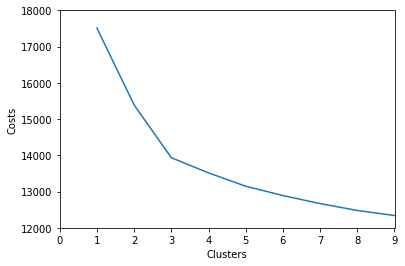

In [34]:
# Plot costs by number of clusters
plt.plot([1, 2, 3, 4, 5, 6, 7, 8, 9], [17513.0, 15391.0, 13934.0, 13515.0, 13148.0, 12890.0, 12668.0, 12479.0, 12339.0])
plt.xlabel('Clusters')
plt.ylabel('Costs')
plt.axis([0, 9, 12000.0, 18000.0])
plt.show()

In [35]:
# Calculate kmodes for 3 clusters
km3 = KModes(n_clusters=3, init='Huang', n_init=10, verbose=1)
clusters = km3.fit_predict(cslice)
print(km.cluster_centroids_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 353, cost: 14316.0
Run 1, iteration: 2/100, moves: 189, cost: 14001.0
Run 1, iteration: 3/100, moves: 67, cost: 13971.0
Run 1, iteration: 4/100, moves: 9, cost: 13971.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 450, cost: 13950.0
Run 2, iteration: 2/100, moves: 101, cost: 13950.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 426, cost: 14200.0
Run 3, iteration: 2/100, moves: 184, cost: 13956.0
Run 3, iteration: 3/100, moves: 11, cost: 13956.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 416, cost: 13956.0
Run 4, iteration: 2/100, moves: 83, cost: 13943.0
Run 4, iteration: 3/100, moves: 4, cost: 13943.0
Init: initializing centroids
Init: initializing clusters
Starting iteration

In [36]:
centroids = km.cluster_centroids_
centroids

array([[10004, 10024, 10029, 10031,     2,     2, 10052,     2, 10657,
        10725, 10726, 10729, 10733, 10740, 10744, 10748,     1,     1,
            1,     1,     1,     2,     2,     1,     1, 10787,     1,
            1,     1,     2,     1,     1,     2,     1,     2,     1],
       [10001, 10024, 10027, 10031,     3,     2, 10052,     2, 10657,
        10724, 10726, 10730, 10733, 10740, 10744, 10749,     1,     1,
            1,     1,     1,     1,     1,     1,     1, 10787,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1],
       [10002, 10023, 10026, 10031,     4,     3, 10052,     1, 10657,
        10722, 10726, 10729, 10733, 10737, 10741, 10745,     1,     1,
            1,     1,     1,     1,     1,     1,     1, 10787,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     0],
       [10001, 10024, 10029, 10031,     3,     2, 10052,     1, 10657,
        10724, 10727, 10730, 10733, 10740, 10744, 10749,     1,     1,
   

In [42]:
# Next step: Explore clusters, visualize and interpret results